# Mapping Global Solutions for a Sustainable Water Future Manuscript
## Development of Figure 2, Comparing GII, SDG 6.5.1 IWRM, and Adaptive Capacity Indicators

<font color=red>Title: Figure 2 in Mapping Global Solutions for a Sustainable Water Future  
Author: Pamela Green  
Date: November 3, 2023  

This code was developed between September-November 2023 by Pamela Green and includes the development and creation of all raster and tabular data included in the manuscript with same title.  </font>
***


# Modules and Functions

In [68]:
import numpy as np
import pandas as pd

import scipy
from scipy.stats import rankdata
import scipy.ndimage as nd

from osgeo import gdal, gdal_array, osr, ogr
from osgeo.gdalconst import *

import subprocess as sp
import os
import xlsxwriter
import matplotlib.pyplot as plt

import math
import geopandas as gpd

from pandas import ExcelWriter


## Function to get circle sizes based on PopDen_2021 values

In [69]:
def get_circle_size(pop_density):
    if pop_density < 10:
        return 10
    elif 10 <= pop_density < 200:
        return 30
    elif 200 <= pop_density < 400:
        return 100
    elif 400 <= pop_density < 600:
        return 150
    elif 600 <= pop_density < 800:
        return 200
    elif 800 <= pop_density < 1000:
        return 300
    else:
        return 500

## Function to get circle sizes based on 2021 Total Populationin millions 

In [70]:
def get_circle_size_tot(pop_mill):
    if pop_mill < 1:
        return 10
    elif 1 <= pop_mill < 10:
        return 30
    elif 10 <= pop_mill < 100:
        return 75
    elif 100 <= pop_mill < 250:
        return 150
    elif 250 <= pop_mill < 500:
        return 300
    else:
        return 500

# Global Variables, Definitions, Datasets

In [71]:
main = os.getcwd( ) + '/'

model_input = str(main) + str("Data/Model_Input/")
model_output = str(main) + str("Data/Model_Output/")

cellarea = str(model_input) + str("cellarea/")
popdir = str(model_input) + str("population/")
TCWBM_dir = str(model_input) + str("WBM/")
threat_dir = str(model_input) + str("RiverThreats/")
gadm_dir = str(model_input) + str("GADM/")
gii_dir = str(model_input) + str("GII/")
susinvopp_gisdata = str(model_output) + str("rasters/")
susinvopp_tabgraph_main = str(model_output) + str("tables/")
susinvopp_graphics = str(model_output) + str("graphics/")

area_uplim = 100

# Compare GII to SDG 6.5.1

/var/folders/y6/9x58kl6j1yqgmt8t07lxs9sm0000gn/T/ipykernel_78593/669663877.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count_iwrm_positive = df_iwmr[(df_combined['IWRMScore'].notnull()) & (df_iwmr['IWRMScore'] > 0)].shape[0]


Number of records where IWRMScore has entries: 185
Number of records where GIIScore has entries: 234

Number of records where IWRMScore has entries > 0: 185
Number of records where GIIScore has entries > 0: 234


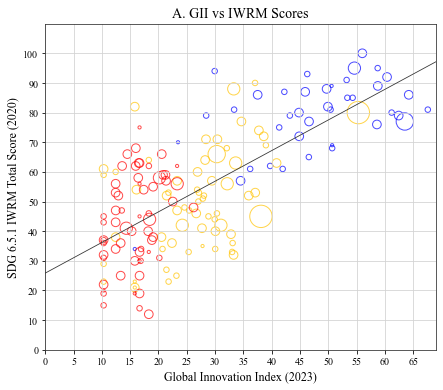

In [72]:
# Read the IWRM data Excel spreadsheet into a pandas dataframe
iwrm_file = str(model_input) + "IWMR/IWRM_country-database-full.xlsx"
sheet_name = "ISO_LOOKUP"

df_iwmr = pd.read_excel(iwrm_file, sheet_name=sheet_name)
df_iwmr = df_iwmr.rename(columns={'GADMID': 'GADMID-IWRM'})
df_iwmr = df_iwmr.rename(columns={'GII': 'GII-IWRM'})
df_iwmr = df_iwmr.rename(columns={'GADM Name': 'GADM Name-IWRM'})
df_iwmr = df_iwmr.rename(columns={'Score': 'AdjScore-IWRM'})
#print(df_iwmr)

# NEW SPREADSHEET FROM CODE - REPRODUCABLE
# Read the GII data from Excel spreadsheet into a pandas dataframe
gii_file = str(model_input) + "GII/All_Years_Final_GII.xlsx"
sheet_name = "Sheet1"
columns_to_read = ['ISO', 'ISO_NUM', 'WBRegion', 'New_Score2023_fill']
df_gii = pd.read_excel(gii_file, sheet_name=sheet_name, usecols=columns_to_read)
df_gii = df_gii.rename(columns={'New_Score2023_fill': 'GIIScore'})

# Read the WorldBank total populations data from xlsx into a pandas dataframe
pop_file = str(model_input) + 'population/API_SP.POP.TOTL_DS2_en_excel_v2_5871620.xls'
sheet_name = "Data"
columns_to_read = ['Country Code', '2020', '2022']
df_pop = pd.read_excel(pop_file, sheet_name=sheet_name, usecols=columns_to_read, skiprows=3)
df_pop = df_pop.rename(columns={'Country Code': 'ISO'})
df_pop = df_pop.rename(columns={'2020': 'PopTot_2020'})
df_pop = df_pop.rename(columns={'2022': 'PopTot_2022'})
df_pop['PopTot_2020'] = df_pop['PopTot_2020'] / 1000000
df_pop['PopTot_2022'] = df_pop['PopTot_2022'] / 1000000

# Read the WorldBank populations density data from csv into a pandas dataframe
popden_file = str(model_input) + 'population/API_EN.POP.DNST_DS2_en_csv_v2_5872351.csv'
columns_to_read = ['Country Code', '2020', '2021']
df_popden = pd.read_csv(popden_file, usecols=columns_to_read, skiprows=4)
df_popden = df_popden.rename(columns={'Country Code': 'ISO'})
df_popden = df_popden.rename(columns={'2020': 'PopDen_2020'})
df_popden = df_popden.rename(columns={'2021': 'PopDen_2021'})

# Read the FAO Country Area into a pandas dataframe
area_file = str(model_input) + 'LandArea/FAOSTAT_data_en_10-6-2023.xls'
sheet_name = "Sheet1"
columns_to_read = ['Area Code (ISO3)', 'Value']
df_area = pd.read_excel(area_file, sheet_name=sheet_name, usecols=columns_to_read)
df_area = df_area.rename(columns={'Area Code (ISO3)': 'ISO'})
df_area = df_area.rename(columns={'Value': 'Country Area 1000ha'})

# 1. Join the two dataframes based on the 'ISO' column
df_combined = pd.merge(df_iwmr, df_gii, on='ISO', how='outer')

# 2. Count the number of records where 'IWRMScore' is not null
count_iwrm_positive = df_iwmr[(df_combined['IWRMScore'].notnull()) & (df_iwmr['IWRMScore'] > 0)].shape[0]
count_iwrm_not_null = df_iwmr['IWRMScore'].notnull().sum()

# 3. Count the number of records where 'GIIScore' is not null
count_gii_positive = df_gii[(df_gii['GIIScore'].notnull()) & (df_gii['GIIScore'] > 0)].shape[0]
count_gii_not_null = df_gii['GIIScore'].notnull().sum()

# Print the results
print(f"Number of records where IWRMScore has entries: {count_iwrm_not_null}")
print(f"Number of records where GIIScore has entries: {count_gii_not_null}")
print()
print(f"Number of records where IWRMScore has entries > 0: {count_iwrm_positive}")
print(f"Number of records where GIIScore has entries > 0: {count_gii_positive}")

df_combined1 = pd.merge(df_combined, df_popden, on='ISO', how='outer')
df_combined2 = pd.merge(df_combined1, df_pop, on='ISO', how='outer')
df_combined3 = pd.merge(df_combined2, df_area, on='ISO', how='outer')

# Filter the combined dataframe 
# Conditions: 
# 1) Both 'IWRMScore' and 'GIIScore' are not null
# 2) Both 'IWRMScore' and 'GIIScore' are greater than 0
df_filtered = df_combined3[
    (df_combined3['IWRMScore'].notnull()) & 
    (df_combined3['GIIScore'].notnull()) & 
    (df_combined3['IWRMScore'] > 0) & 
    (df_combined3['GIIScore'] > 0) &
    (df_combined3['PopTot_2022'].notnull()) & 
    (df_combined3['Country Area 1000ha'] > area_uplim)
]

df_filtered = df_filtered[df_filtered['WBRegion'].isin(['High Income', 'Middle Income', 'Low Income'])]

# Create a color map for the 'WBRegion' column with hex color values
color_map = {
    'High Income': '#0000FF',   # blue in hex
    'Middle Income': '#FFC300', # yellow in hex
    'Low Income': '#FF0000'     # red in hex
}

# Default color for other values
default_color = 'gray'

# Create a new column 'color' in df_filtered to map the colors based on 'WBRegion'
df_filtered.loc[:, 'color'] = df_filtered['WBRegion'].map(lambda x: color_map.get(x, default_color))
    
# Create a new column 'size' in df_filtered to map circle sizes based on 'PopDen_2021' values
#df_filtered.loc[:, 'size'] = df_filtered['PopDen_2021'].apply(get_circle_size)
df_filtered.loc[:, 'size'] = df_filtered['PopTot_2022'].apply(get_circle_size_tot)

# Compute the trend line
x = df_filtered['GIIScore']
y = df_filtered['IWRMScore']
z = np.polyfit(x, y, 1) # 1 for linear regression
p = np.poly1d(z)

# Define the x-values for the trend line, extending from minimum to maximum x-values
right_bound = math.ceil(df_filtered['GIIScore'].max()) + 1
top_bound = math.ceil(df_filtered['IWRMScore'].max()) + 10

x_trend = np.array([0, right_bound])

# Prepare custom legend handles for 'High Income', 'Middle Income', and 'Low Income'
legend_handles = [plt.Line2D([0], [0], marker='o', color='white', markerfacecolor=color_map[region], markersize=10, label=region) for region in color_map.keys()]

# Create custom legend handles for circle sizes
size_labels = ["<10", "10-200", "200-400", "400-600", "600-800", "800-1,000", ">1,000"]
sizes = [10, 30, 100, 150, 200, 300, 500]
size_handles = [plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='darkgray', markersize=math.sqrt(size), label=label) for size, label in zip(sizes, size_labels)]

# Plotting the data with color-coded bubbles
plt.figure(figsize=(7,6))

# Set the font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

for region, color in color_map.items():
    subset = df_filtered[df_filtered['WBRegion'] == region]
    plt.scatter(subset['GIIScore'], subset['IWRMScore'], s=subset['size'], edgecolors=color, alpha=0.7, facecolors='none')
    
# Plotting the data for other values (gray points)
other_subset = df_filtered[~df_filtered['WBRegion'].isin(color_map.keys())]
plt.scatter(other_subset['GIIScore'], other_subset['IWRMScore'], s=other_subset['size'], edgecolors=default_color, alpha=0.7, facecolors='none')

# Plotting the trend line
plt.plot(x_trend, p(x_trend), color='#333333', linestyle='-', linewidth=0.8)  # using a solid line for the trend line

plt.title('A. GII vs IWRM Scores', fontsize=14)
plt.xlabel('Global Innovation Index (2023)', fontsize=12)
plt.ylabel('SDG 6.5.1 IWRM Total Score (2020)', fontsize=12)
plt.grid(True)

# # Add the legend for World Bank Income Group without title
# legend1 = plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.05, 0.0), handlelength=1)
# plt.gca().add_artist(legend1)  # Add this to keep the first legend when adding the second

# # Manually set the title for the first legend
# plt.text(1.065, 0.11, 'World Bank \nIncome Group', transform=plt.gca().transAxes, va='center', ha='left', fontsize=10)

# # Add the legend for circle sizes without title
# legend2 = plt.legend(handles=size_handles, loc='center left', bbox_to_anchor=(1.05, 0.35), handlelength=2, fontsize=10, borderpad=0.75)

# # Manually set the title for the second legend
# plt.text(1.065, 0.57, 'Population Density\n(people/km$^2$)', transform=plt.gca().transAxes, va='center', ha='left', fontsize=10)

# Set both X and Y axes
plt.gca().set_xlim(left=0, right=right_bound)
plt.gca().set_ylim(bottom=0, top=top_bound)

# Set x-axis ticks at intervals of 5
plt.xticks(np.arange(0, right_bound, 5))

# Set y-axis ticks at intervals of 10
plt.yticks(np.arange(0, top_bound, 10))

# Set grid properties
plt.grid(True, color='lightgray', linestyle='-')

# Set the color of the plot border (spines)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('#333333')  # Dark gray color, similar to the trend line

name = str(susinvopp_graphics) + 'Fig2A.png'
plt.savefig(name, dpi=250, bbox_inches='tight', facecolor='white')

plt.show()


# Create Area-Weighted Means of Adaptive Capacity (Varis et al) by GADM Country

## Import Adaptive capacity raster to numpy

In [73]:
n = 360
main = "/Users/pamelagreen/Desktop/Data/"
ac_dir = str(main) + "Varis_etal_2019/"
gadm_dir = str(main) + "political/gadm/gadm_v2_shp/shapefiles/"

# Step 1: Extract Band 26 from the netCDF file

netcdf_file = str(ac_dir) + "adaptive_capacity.nc"
band_number = 26

# Open the netCDF file using GDAL
ds = gdal.Open(netcdf_file)

# Get the specific band
band = ds.GetRasterBand(band_number)

# Convert the band to a numpy array
ac_array = band.ReadAsArray()

#ac_array[np.isnan(ac_array)] = 0
ac_array[ac_array < 0] = np.nan
ac_array = ac_array[:-n, :]


Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute


## Import GADM country polygons, convert to raster and numpy array

In [74]:
# File paths
shapefile_path = str(gadm_dir) + 'gadm2cnty.shp'

# Raster dimensions and other parameters
x_size = 4320
y_size = 2160
pixel_size = 0.0833333
no_data_value = -9999.0
attribute = "ISO_NUM"
outputBounds = [-180, -90, 180, 90]

# Open the shapefile
shp_ds = ogr.Open(shapefile_path)
shp_lyr = shp_ds.GetLayer()

# Create an in-memory raster dataset to rasterize into
mem_drv = gdal.GetDriverByName('MEM')
raster_ds = mem_drv.Create('', x_size, y_size, 1, gdal.GDT_Float32)
raster_ds.SetGeoTransform((outputBounds[0], pixel_size, 0, outputBounds[3], 0, -pixel_size))
raster_ds.SetProjection(shp_lyr.GetSpatialRef().ExportToWkt())
band = raster_ds.GetRasterBand(1)
band.SetNoDataValue(no_data_value)
band.Fill(no_data_value)

# Rasterize the shapefile layer using the 'ISO_NUM' attribute for pixel values
gdal.RasterizeLayer(raster_ds, [1], shp_lyr, options=[f"ATTRIBUTE={attribute}"])

# Convert to numpy array
gadm_array = band.ReadAsArray()

gadm_array[np.isnan(gadm_array)] = 0
gadm_array = gadm_array[:-n, :]

## Import 5min Cellarea

In [75]:
cell_dir = '/Users/pamelagreen/Desktop/Data/cellarea/'
cellarea_file = str(cell_dir) + 'CellArea_5m.tif'
ds = gdal.Open(str(cellarea_file))
CellArea = np.array(ds.GetRasterBand(1).ReadAsArray())

CellArea[np.isnan(CellArea)] = 0
CellArea = CellArea[:-n, :]

## Create Area-weighted Adaptive Capacity values by country iso

In [76]:
# Identify unique iso_num values
unique_iso_nums = np.unique(gadm_array)

# Create an empty dictionary to store results
results = {}

for iso_num in unique_iso_nums:
    # Mask arrays for the current iso_num
    mask = (gadm_array == iso_num)
    
    # Calculate the sum of (ac_array * CellArea) for the current iso_num
    #sum_weighted_ac = np.sum(ac_array[mask] * CellArea[mask])
    sum_weighted_ac = np.nansum(ac_array[mask] * CellArea[mask])
    
    # Calculate the sum of CellArea for the current iso_num
    #sum_area = np.sum(CellArea[mask])
    sum_area = np.nansum(CellArea[mask])
    
    # Calculate the area-weighted average for the current iso_num
    if sum_area != 0:  # To prevent division by zero
        area_weighted_avg = sum_weighted_ac / sum_area
        results[iso_num] = area_weighted_avg
    else:
        results[iso_num] = np.nan  # or some other placeholder for no data

df_ac = pd.DataFrame(list(results.items()), columns=['ISO_NUM', 'Adaptive Capacity Avg'])
df_ac = df_ac[(df_ac['ISO_NUM'] > 0)]

max_val = df_ac['Adaptive Capacity Avg'].max()
df_ac['Adaptive Capacity Lin'] = df_ac['Adaptive Capacity Avg'] / max_val

# Write the DataFrame to an Excel file

writer = ExcelWriter(str(ac_dir) + 'avg_ac_gadmISO.xlsx')
df_ac.to_excel(writer, 'Sheet1', index=False)
writer.save()

output_csv = str(ac_dir) + "avg_ac_gadmISO.csv"
df_ac.to_csv(output_csv, index=False)


# Compare GII to Adaptive Capacity (Varis et al)

## Create GII vs Adaptive Capacity Plot

Number of records where Adaptive Capacity has entries: 236
Number of records where GIIScore has entries: 234

Number of records where Adaptive Capacity has entries > 0: 224
Number of records where GIIScore has entries > 0: 234


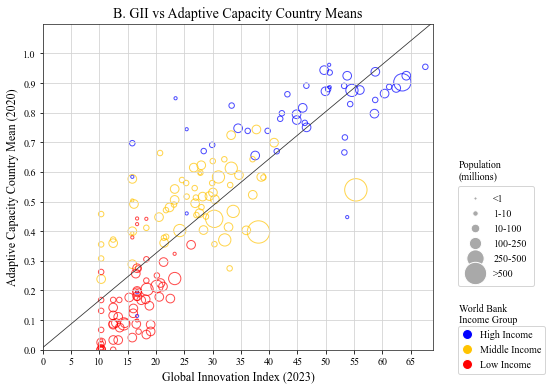

In [83]:
# 1. Join the two dataframes based on the 'ISO' column
df_combined = pd.merge(df_ac, df_gii, on='ISO_NUM', how='outer')

# 2. Count the number of records where 'acScore' is not null
count_ac_positive = df_ac[(df_ac['Adaptive Capacity Avg'].notnull()) & (df_ac['Adaptive Capacity Avg'] > 0)].shape[0]
count_ac_not_null = df_ac['Adaptive Capacity Avg'].notnull().sum()

# 3. Count the number of records where 'GIIScore' is not null
count_gii_positive = df_gii[(df_gii['GIIScore'].notnull()) & (df_gii['GIIScore'] > 0)].shape[0]
count_gii_not_null = df_gii['GIIScore'].notnull().sum()

# Print the results
print(f"Number of records where Adaptive Capacity has entries: {count_ac_not_null}")
print(f"Number of records where GIIScore has entries: {count_gii_not_null}")
print()
print(f"Number of records where Adaptive Capacity has entries > 0: {count_ac_positive}")
print(f"Number of records where GIIScore has entries > 0: {count_gii_positive}")

df_combined1 = pd.merge(df_combined, df_popden, on='ISO', how='outer')
df_combined2 = pd.merge(df_combined1, df_pop, on='ISO', how='outer')
df_combined3 = pd.merge(df_combined2, df_area, on='ISO', how='outer')

# Filter the combined dataframe 
# Conditions: 
# 1) Both 'Adaptive Capacity Avg' and 'GIIScore' are not null
# 2) Both 'Adaptive Capacity Avg' and 'GIIScore' are greater than 0
df_filtered = df_combined3[
    (df_combined3['Adaptive Capacity Avg'].notnull()) & 
    (df_combined3['GIIScore'].notnull()) & 
    (df_combined3['Adaptive Capacity Avg'] > 0) & 
    (df_combined3['GIIScore'] > 0) &
    (df_combined3['PopTot_2022'].notnull()) & 
    (df_combined3['Country Area 1000ha'] > area_uplim)
]

df_filtered = df_filtered[df_filtered['WBRegion'].isin(['High Income', 'Middle Income', 'Low Income'])]

# Create a color map for the 'WBRegion' column with hex color values
color_map = {
    'High Income': '#0000FF',   # blue in hex
    'Middle Income': '#FFC300', # yellow in hex
    'Low Income': '#FF0000'     # red in hex
}

# Default color for other values
default_color = 'gray'

# Create a new column 'color' in df_filtered to map the colors based on 'WBRegion'
df_filtered.loc[:, 'color'] = df_filtered['WBRegion'].map(lambda x: color_map.get(x, default_color))

# Create a new column 'size' in df_filtered to map circle sizes based on 'PopDen_2021' values
#df_filtered.loc[:, 'size'] = df_filtered['PopDen_2021'].apply(get_circle_size)
df_filtered.loc[:, 'size'] = df_filtered['PopTot_2022'].apply(get_circle_size_tot)

# print(df_filtered)
# Compute the trend line
x = df_filtered['GIIScore']
y = df_filtered['Adaptive Capacity Avg']
z = np.polyfit(x, y, 1) # 1 for linear regression
p = np.poly1d(z)

# Define the x-values for the trend line, extending from minimum to maximum x-values
right_bound = math.ceil(df_filtered['GIIScore'].max()) + 1
top_bound = math.ceil(df_filtered['Adaptive Capacity Avg'].max()) + 0.1

x_trend = np.array([0, right_bound])

# Prepare custom legend handles for 'High Income', 'Middle Income', and 'Low Income'
legend_handles = [plt.Line2D([0], [0], marker='o', color='white', markerfacecolor=color_map[region], markersize=10, label=region) for region in color_map.keys()]

# Create custom legend handles for circle sizes
#size_labels = ["<10", "10-200", "200-400", "400-600", "600-800", "800-1,000", ">1,000"]
size_labels = ["<1", "1-10", "10-100", "100-250", "250-500", ">500"]
sizes = [10, 30, 75, 150, 300, 500]
size_handles = [plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='darkgray', markersize=math.sqrt(size), label=label) for size, label in zip(sizes, size_labels)]

# Plotting the data with color-coded bubbles
plt.figure(figsize=(7,6))

# Set the font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

for region, color in color_map.items():
    subset = df_filtered[df_filtered['WBRegion'] == region]
    plt.scatter(subset['GIIScore'], subset['Adaptive Capacity Avg'], s=subset['size'], edgecolors=color, alpha=0.7, facecolors='none')
    
# Plotting the data for other values (gray points)
other_subset = df_filtered[~df_filtered['WBRegion'].isin(color_map.keys())]
plt.scatter(other_subset['GIIScore'], other_subset['Adaptive Capacity Avg'], s=other_subset['size'], edgecolors=default_color, alpha=0.7, facecolors='none')

# Plotting the trend line
plt.plot(x_trend, p(x_trend), color='#333333', linestyle='-', linewidth=0.8)  # using a solid line for the trend line

plt.title('B. GII vs Adaptive Capacity Country Means', fontsize=14)
plt.xlabel('Global Innovation Index (2023)', fontsize=12)
plt.ylabel('Adaptive Capacity Country Mean (2020)', fontsize=12)
plt.grid(True)

# Add the legend for World Bank Income Group without title
legend1 = plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.05, 0.0), handlelength=1)
plt.gca().add_artist(legend1)  # Add this to keep the first legend when adding the second

# Manually set the title for the first legend
plt.text(1.065, 0.11, 'World Bank \nIncome Group', transform=plt.gca().transAxes, va='center', ha='left', fontsize=10)

# Add the legend for circle sizes without title
legend2 = plt.legend(handles=size_handles, loc='center left', bbox_to_anchor=(1.05, 0.35), handlelength=2, fontsize=10, borderpad=0.75)

# Manually set the title for the second legend
#plt.text(1.065, 0.57, 'Population Density\n(people/km$^2$)', transform=plt.gca().transAxes, va='center', ha='left', fontsize=10)
plt.text(1.065, 0.55, 'Population\n(millions)', transform=plt.gca().transAxes, va='center', ha='left', fontsize=10)

# Set both X and Y axes
plt.gca().set_xlim(left=0, right=right_bound)
plt.gca().set_ylim(bottom=0, top=top_bound)

# Set x-axis ticks at intervals of 5
plt.xticks(np.arange(0, right_bound, 5))

# Set y-axis ticks at intervals of 10
plt.yticks(np.arange(0, top_bound, 0.1))

# Set grid properties
plt.grid(True, color='lightgray', linestyle='-')

# Set the color of the plot border (spines)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('#333333')  # Dark gray color, similar to the trend line

name = str(susinvopp_graphics) + 'Fig2B.png'
plt.savefig(name, dpi=250, bbox_inches='tight', facecolor='white')

plt.show()


In [78]:
name = str(susinvopp_graphics) + 'df_filtered.xlsx'
writer = ExcelWriter(str(name))
df_filtered.to_excel(writer, 'Sheet1', index=False)
writer.save()